# Importing Libraries and Datasets

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from sklearn import linear_model, feature_selection, metrics, model_selection, datasets
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as smf
import pypalettes
import warnings
warnings.filterwarnings('ignore')

counties_pol_party = pd.read_csv('counties_pol.csv')

In [11]:
counties_pol_party.shape
counties_pol_party.reset_index(inplace=True)
counties_pol_party = counties_pol_party.drop(columns='index')

In [12]:
# changing fips to str value
counties_pol_party['fips']= counties_pol_party['fips'].astype(str)

## Standardizing Values

In [13]:
independent_vars = ['income_inequality', 'gender_pay_gap',
       'school_segration_index', 'residential_segregation',
       'school_funding_gap']

dependent_vars = ['hs_diploma_percentage', 'unemployed_percentage', 'population', 'median_income', 'uninsured__percentage', 'premature_death', 'child_poverty_percentage', 'life_expectancy', 'child_mortality', 'high_housing_cost_percentage', 'firearm_fatalities', 'child_care_cost_burden']
vars_to_z = independent_vars + dependent_vars
counties_pol_copy = counties_pol_party.copy()

In [14]:
# multiplies each percentage column by county polulation to yield total amounts
def calc_z(df, cols):
    for i in df[cols]:
        df[i] = np.abs(stats.zscore(df[i])) 
    return df

In [15]:
z_counties= calc_z(counties_pol_copy, vars_to_z)

# Variable Selection with Pairwise Mutual Information 

In [16]:
# Initialize a matrix to store mutual information
mutual_info_matrix = np.zeros((len(independent_vars), len(dependent_vars)))

# Calculate mutual information for each independent-dependent variable pair
for i, var1 in enumerate(independent_vars):
    for j, var2 in enumerate(dependent_vars):
        X = counties_pol_party[[var1]]
        y = counties_pol_party[var2]
        mutual_info = mutual_info_regression(X, y)
        mutual_info_matrix[i, j] = mutual_info[0]  # Store the mutual info scalar

# Convert the matrix to a DataFrame for easier viewing
mutual_info_df = pd.DataFrame(mutual_info_matrix, index=independent_vars, columns=dependent_vars)

# Display the mutual information DataFrame
print(mutual_info_df)

                         hs_diploma_percentage  unemployed_percentage  \
income_inequality                     0.114925               0.076224   
gender_pay_gap                        0.046747               0.000000   
school_segration_index                0.022738               0.049320   
residential_segregation               0.047591               0.009900   
school_funding_gap                    0.225012               0.040509   

                         population  median_income  uninsured__percentage  \
income_inequality          0.025887       0.209566               0.072039   
gender_pay_gap             0.068439       0.024641               0.034895   
school_segration_index     0.182006       0.028126               0.009920   
residential_segregation    0.080866       0.021754               0.068292   
school_funding_gap         0.088499       0.249608               0.251498   

                         premature_death  child_poverty_percentage  \
income_inequality           

## Visualizing Pairwise Mutual Information as Heatmap

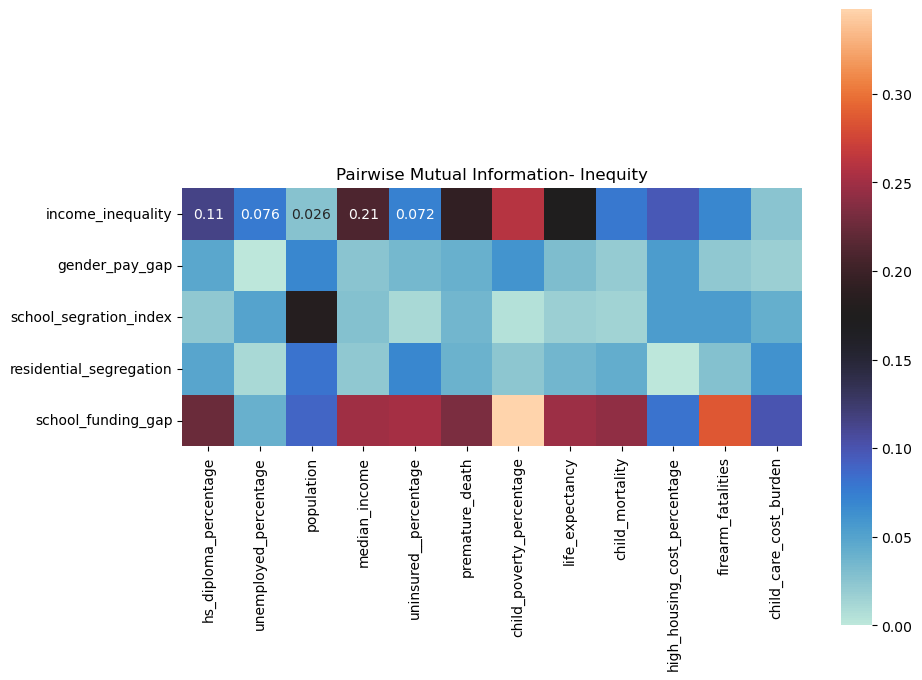

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(mutual_info_df, annot=True, cmap='icefire', square=True)
plt.title('Pairwise Mutual Information- Inequity')
plt.show()

# Identifying most 'informative' pairs

In [18]:
top_var_pairs = mutual_info_df.unstack().sort_values(ascending=False).head(12)
print(top_var_pairs)

child_poverty_percentage  school_funding_gap        0.347780
firearm_fatalities        school_funding_gap        0.286386
child_poverty_percentage  income_inequality         0.260142
uninsured__percentage     school_funding_gap        0.251498
median_income             school_funding_gap        0.249608
life_expectancy           school_funding_gap        0.248405
child_mortality           school_funding_gap        0.242564
premature_death           school_funding_gap        0.232733
hs_diploma_percentage     school_funding_gap        0.225012
median_income             income_inequality         0.209566
premature_death           income_inequality         0.192543
population                school_segration_index    0.182006
dtype: float64


### Selecting most 'informative' variables
- x: 'school_funding_gap', 'income_inequality'
- y: 'child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'

*including political party elected from 2020 general election for additional comparative visualizations*

In [19]:
high_mutual_info_vars = ['state_abbr', 'county', 'fips', 'school_funding_gap', 'child_poverty_percentage', 'income_inequality', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death', 'political_party']
agg_select_subset = counties_pol_party[high_mutual_info_vars]
x_vars= ['school_funding_gap', 'income_inequality']
y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death']

# Descriptive Statistics for Selected Variables

In [20]:
agg_select_subset.describe().round(2)

,school_funding_gap,child_poverty_percentage,income_inequality,firearm_fatalities,median_income,life_expectancy,premature_death
count,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00
mean,-804.97,0.19,4.60,16.77,67337.94,74.85,10482.46
std,6428.72,0.08,0.71,7.60,16490.49,3.22,3315.20
min,-46776.99,0.03,2.88,1.86,34176.00,63.84,3990.29
25%,-3452.36,0.13,4.10,11.69,55568.00,72.60,8089.24
50%,-309.82,0.18,4.49,15.87,64090.50,74.88,10155.80
75%,2283.42,0.23,4.98,20.47,75447.00,77.07,12482.99
max,21187.84,0.54,8.28,79.46,144807.00,89.67,27851.41


In [119]:
sns.set_theme(style='whitegrid', palette='icefire')

def plot_histograms_boxplots(data, columns):
    fig, axes = plt.subplots(len(columns), 2, figsize=(12, 4 * len(columns)))
    for i, col in enumerate(columns):
        # Histogram
        sns.histplot(data[col], kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Histogram of {col}')
        # Boxplot
        sns.boxplot(x=data[col], ax=axes[i, 1])
        axes[i, 1].set_title(f'Boxplot of {col}')
    plt.tight_layout()

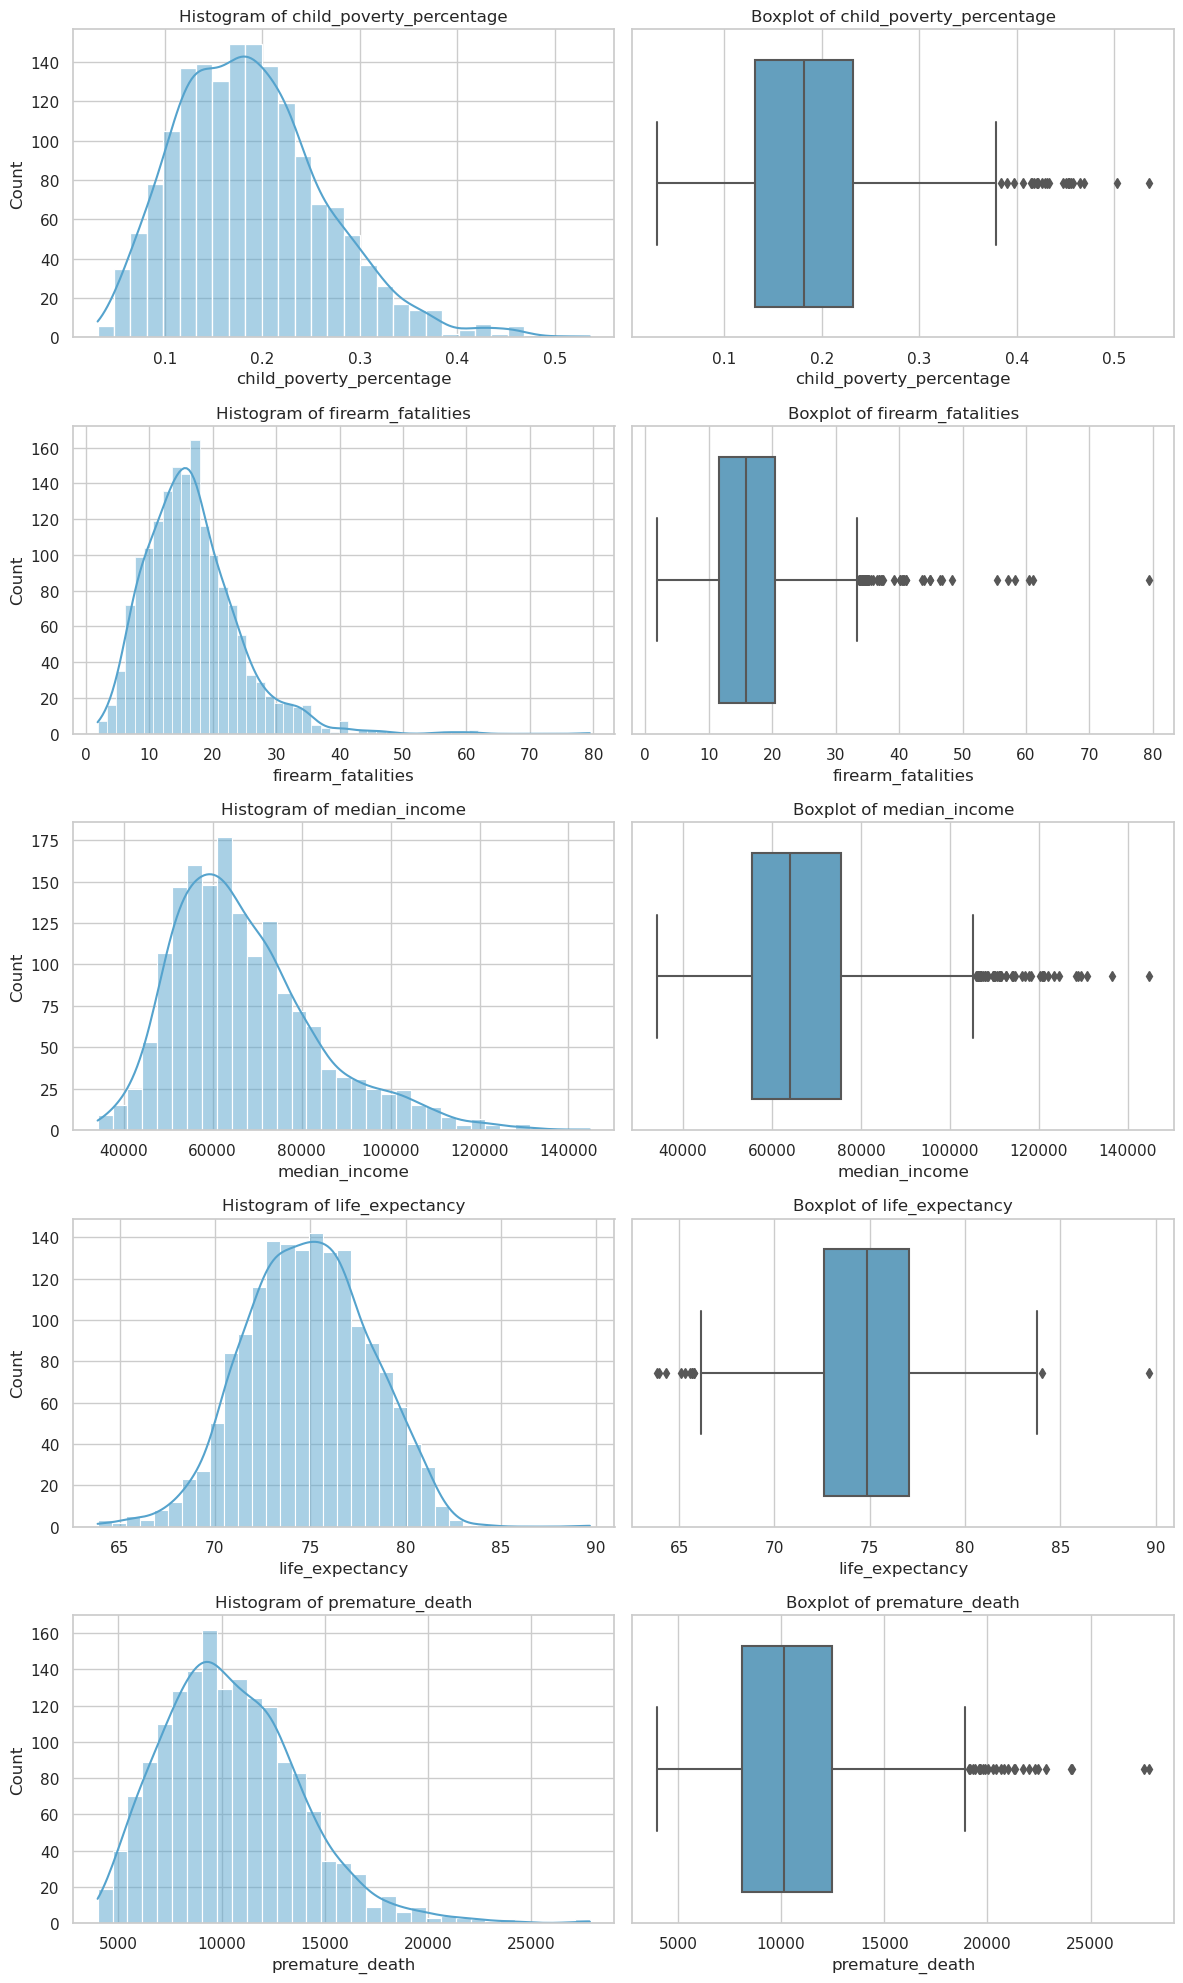

In [117]:
plot_histograms_boxplots(agg_select_subset, y_vars)

In [ ]:

# Columns of interest for both datasets
columns_of_interest = ['age', 'studytime', 'failures', 'G1', 'G2', 'G3']

# Plotting for Mathematics dataset
plot_histograms_boxplots(mat_data, columns_of_interest, 'Mathematics')

## Variance 

In [22]:
agg_select_subset.var(numeric_only=True)

school_funding_gap          4.132847e+07
child_poverty_percentage    5.870140e-03
income_inequality           5.075141e-01
firearm_fatalities          5.772999e+01
median_income               2.719364e+08
life_expectancy             1.040037e+01
premature_death             1.099053e+07
dtype: float64

## Correlation 

<Axes: >

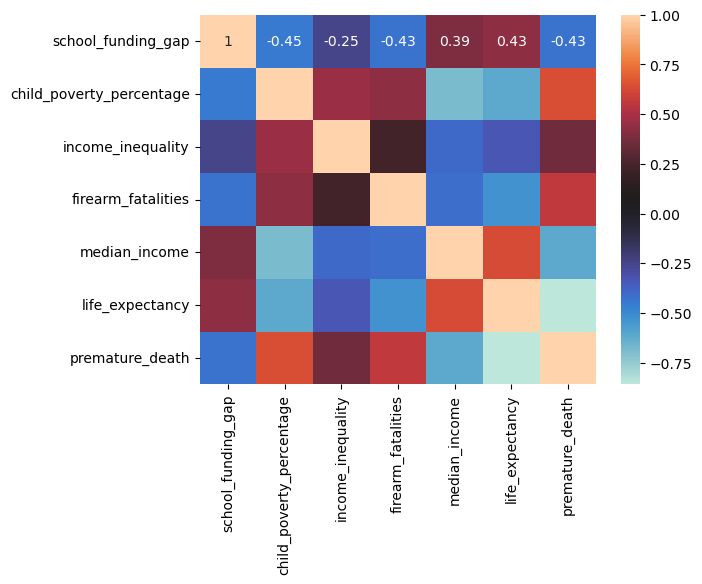

In [23]:
corr_matrix = agg_select_subset.corr(method='kendall', numeric_only=True).round(2)
sns.heatmap(corr_matrix, annot=True, cmap='icefire')

### Correlation Pairs

In [24]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['school_funding_gap']))

child_poverty_percentage   -0.637112
firearm_fatalities         -0.604100
median_income               0.496392
life_expectancy             0.564720
premature_death            -0.579993
dtype: float64


In [25]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['income_inequality']))

child_poverty_percentage    0.622599
firearm_fatalities          0.366110
median_income              -0.503023
life_expectancy            -0.458570
premature_death             0.512731
dtype: float64


### Covariance

In [26]:
agg_select_subset.cov(numeric_only=True).round(2)

,school_funding_gap,child_poverty_percentage,income_inequality,firearm_fatalities,median_income,life_expectancy,premature_death
school_funding_gap,41328467.77,-313.81,-1604.99,-29507.62,5.262393e+07,11707.99,-12361094.39
child_poverty_percentage,-313.81,0.01,0.03,0.36,-1.025680e+03,-0.19,206.09
income_inequality,-1604.99,0.03,0.51,1.98,-5.909430e+03,-1.05,1210.94
firearm_fatalities,-29507.62,0.36,1.98,57.73,-6.751643e+04,-16.64,18173.46
median_income,52623929.12,-1025.68,-5909.43,-67516.43,2.719364e+08,41980.70,-41437689.02
life_expectancy,11707.99,-0.19,-1.05,-16.64,4.198070e+04,10.40,-10274.20
premature_death,-12361094.39,206.09,1210.94,18173.46,-4.143769e+07,-10274.20,10990534.91


## Pair Plots

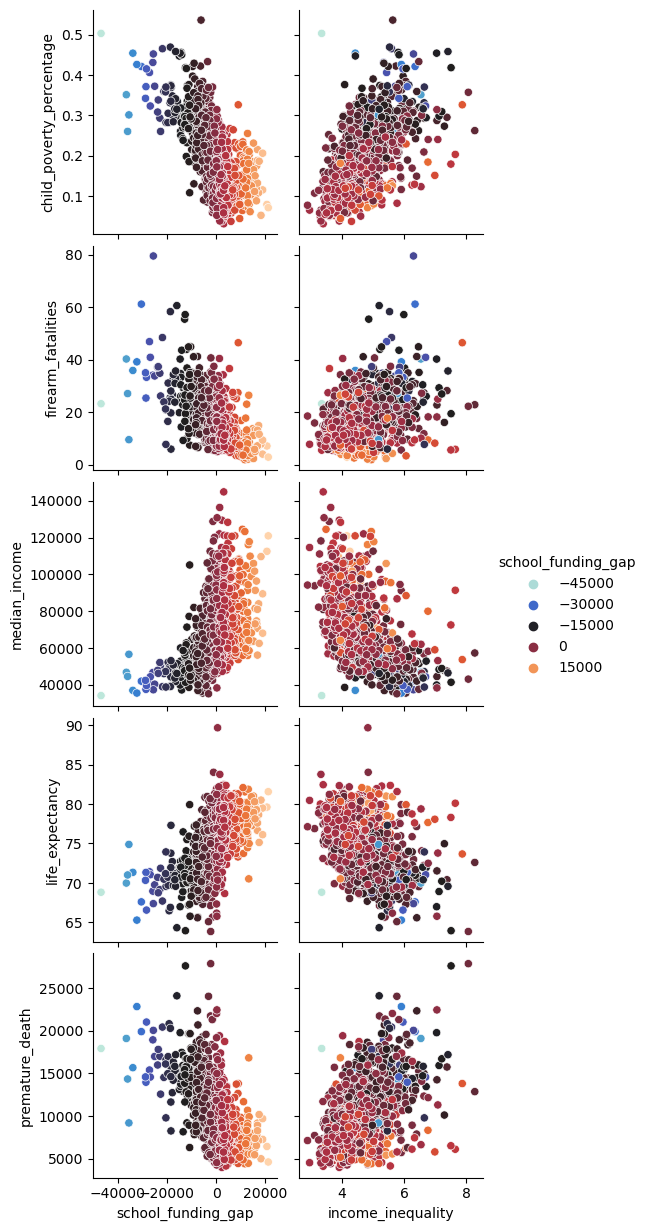

In [27]:
sns.pairplot(agg_select_subset, 
    x_vars= ['school_funding_gap', 'income_inequality'],
    y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'],
    hue = 'school_funding_gap',
    palette='icefire',
    )     

# Regression: Selecting Best Model 

focusing on highest correlation pairs:
### school_funding
- child_poverty_percentage
- firearm_fatalities
- life_expectancy 

### income_inequality 
- child_poverty_percentage
- median_income
- premature_death

In [58]:
X_1 = agg_select_subset['school_funding_gap']
X_2 = agg_select_subset['income_inequality']
y_1 = agg_select_subset['child_poverty_percentage']
y_2 = agg_select_subset['firearm_fatalities']
y_3 = agg_select_subset['median_income']
y_4 = agg_select_subset['life_expectancy']
y_5 = agg_select_subset['premature_death']


## Linear Regression


Define function for plotting pairs of interest individually

In [ ]:
def poly_reg_line(x_val, y_val, slope_val, intercept_val):
    sns.scatterplot(x = x_val, y = y_val, hue = x_val, palette ='icefire') 
    slope_val, intercept_val = np.polyfit(x_val, y_val, 1)
    plt.plot(x_val, slope_val*x_val + intercept_val, color=line_color_2)

### Plotting School Funding 

#### Child Poverty

In [62]:
model_1= smf.ols(formula='child_poverty_percentage ~ school_funding_gap', data=agg_select_subset).fit()
intercept_1 = model_1.params.Intercept
slope_1 = model_1.params.school_funding_gap
line_color_1='#2D83A6'

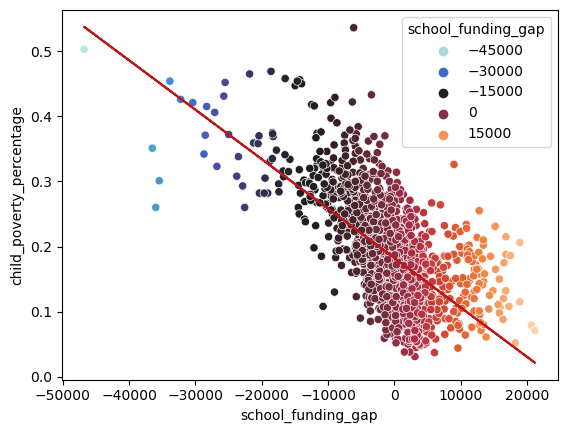

In [80]:
poly_reg_line(X_1, y_1, slope_1, intercept_1)

#### Firearm Fatalities 

In [55]:
model_2= smf.ols(formula='firearm_fatalities ~ school_funding_gap', data=agg_select_subset).fit()
intercept_2 = model_2.params.Intercept
slope_2 = model_2.params.school_funding_gap
line_color_2 = '#BF1717'

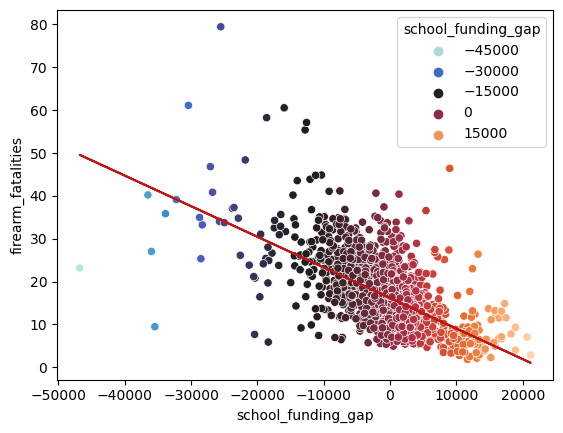

In [82]:
poly_reg_line(X_1, y_2, slope_2, intercept_2)

#### Life Expectency- try polyfit

In [64]:
model_3= smf.ols(formula='life_expectancy ~ school_funding_gap', data=agg_select_subset).fit()
intercept_3 = model_3.params.Intercept
slope_3 = model_3.params.school_funding_gap

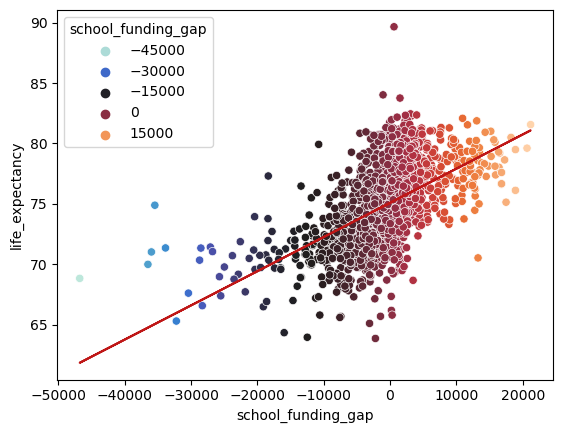

In [83]:
poly_reg_line(X_1, y_4, slope_3, intercept_3)

### Plotting Income Inequality 

In [72]:
def poly_reg_line(x_val, y_val, slope_val, intercept_val):
    sns.scatterplot(x = x_val, y = y_val, hue = x_val, palette ='icefire') 
    slope_val, intercept_val = np.polyfit(x_val, y_val, 1)
    plt.plot(x_val, slope_val*x_val + intercept_val, color=line_color_2)

In [66]:
model_4= smf.ols(formula='life_expectancy ~ income_inequality', data=agg_select_subset).fit()
intercept_4 = model_4.params.Intercept
slope_4 = model_4.params.income_inequality

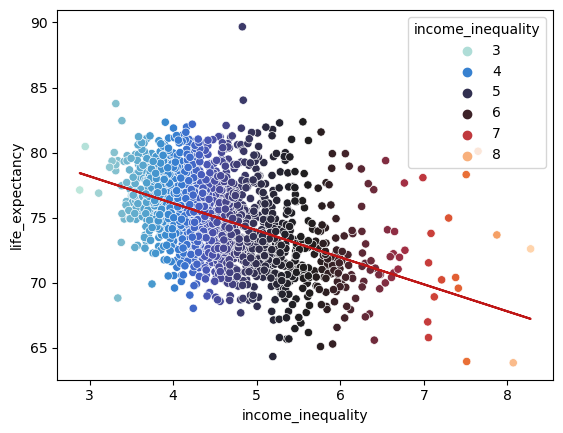

In [73]:
poly_reg_line(X_2, y_4, slope_4, intercept_4)

#### Child Poverty

In [74]:
model_5= smf.ols(formula='child_poverty_percentage ~ income_inequality', data=agg_select_subset).fit()
intercept_5 = model_5.params.Intercept
slope_5 = model_5.params.income_inequality

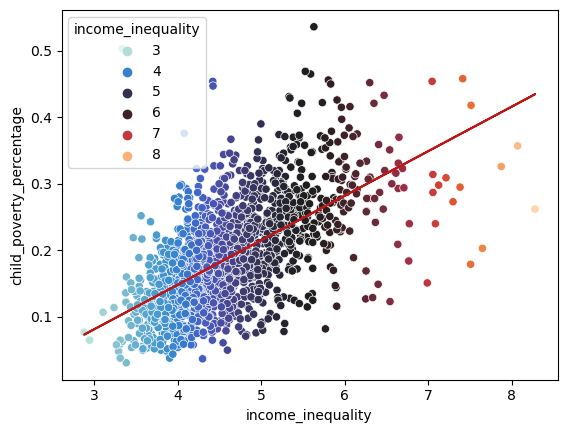

In [75]:
poly_reg_line(X_2, y_1, slope_5, intercept_5)

#### Median Income

In [77]:
model_6= smf.ols(formula='median_income ~ income_inequality', data=agg_select_subset).fit()
intercept_6 = model_6.params.Intercept
slope_6 = model_6.params.income_inequality

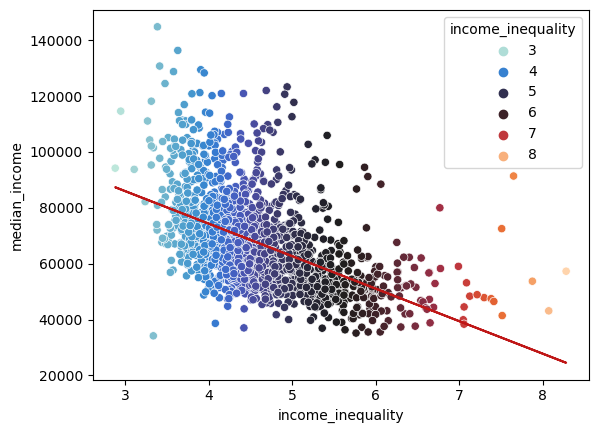

In [78]:
poly_reg_line(X_2, y_3, slope_6, intercept_6)

## Multi-target- MultiRegressor

In [92]:
x_s = agg_select_subset[['school_funding_gap']]
y_s = agg_select_subset[['child_poverty_percentage', 'firearm_fatalities', 'premature_death']]

In [93]:
X, y = x_s, y_s
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [94]:
# Create and train the multi-target regression model (ElasticNet)
multioutput_model = MultiOutputRegressor(
    ElasticNet(alpha=0.5, l1_ratio=0.5), n_jobs=5)
multioutput_model.fit(X_train, y_train)

# Create and train the decision tree regressor model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Create and train the random forest regressor model
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [95]:
# Make predictions
multioutput_pred = multioutput_model.predict(X_test)
tree_pred = tree_model.predict(X_test)
forest_pred = forest_model.predict(X_test)
 
# Calculate performance metrics for multioutput model
multioutput_mse = mean_squared_error(y_test, multioutput_pred)
multioutput_mae = mean_absolute_error(y_test, multioutput_pred)
 
# Calculate performance metrics for decision tree model
tree_mse = mean_squared_error(y_test, tree_pred)
tree_mae = mean_absolute_error(y_test, tree_pred)

# Calculate performance metrics for random forest model
forest_mse = mean_squared_error(y_test, forest_pred)
forest_mae = mean_absolute_error(y_test, forest_pred)

# Print the performance metrics
print("Multioutput Model - Mean Squared Error:", multioutput_mse)
print("Multioutput Model - Mean Absolute Error:", multioutput_mae)
print("Decision Tree Model - Mean Squared Error:", tree_mse)
print("Decision Tree Model - Mean Absolute Error:", tree_mae)
print("Random Forest Model - Mean Squared Error:", forest_mse)
print("Random Forest Model - Mean Absolute Error:", forest_mae)

Multioutput Model - Mean Squared Error: 2564566.4458838087
Multioutput Model - Mean Absolute Error: 688.395513007291
Decision Tree Model - Mean Squared Error: 4817744.602264917
Decision Tree Model - Mean Absolute Error: 978.7717797979803
Random Forest Model - Mean Squared Error: 3341823.774260262
Random Forest Model - Mean Absolute Error: 819.3617219494948


### MSE/MAE Comparative Visualization

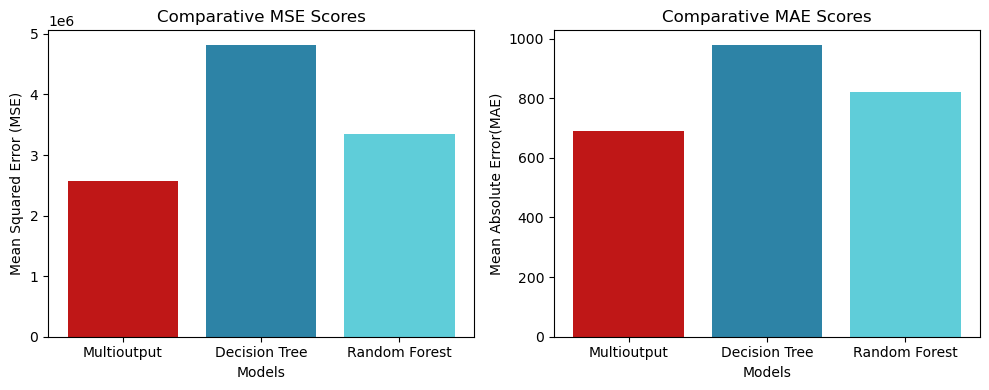

In [96]:
# Create a comparative visualization
plt.figure(figsize=(10, 4))
models = ['Multioutput', 'Decision Tree', 'Random Forest']
mse_scores = [multioutput_mse, tree_mse, forest_mse]
mae_scores = [multioutput_mae, tree_mae, forest_mae]
 
# Plot Mean Squared Error (MSE)
plt.subplot(1, 2, 1)
plt.bar(models, mse_scores, color=['#BF1717', '#2D83A6', '#5FCDD9'])
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparative MSE Scores')

# Plot R-squared Score (R2)
plt.subplot(1, 2, 2)
plt.bar(models, mae_scores, color=['#BF1717', '#2D83A6', '#5FCDD9'])
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error(MAE)')
plt.title('Comparative MAE Scores')

plt.tight_layout()
plt.show()

Multiouput model performed bets out of the 3 compared

## Polynomial

### Testing one Pair at a Time

#### Scool-Funding vs. Child Poverty

In [97]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
# converting x to numpy array, then reshaping to 2D to use in PolynomialFeatures
#X_vector = X.to_numpy()
#X_reshaped = X_vector.reshape(-1, 1)

In [98]:
poly_features = poly.fit_transform(X_1.values.reshape(-1, 1))
# Create a polynomial regression model
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_1)
# Make predictions  
y_predicted = poly_reg_model.predict(poly_features)

In [100]:
print(poly_reg_model.intercept_)
print(poly_reg_model.coef_)

0.18040801095623343
[-7.14102916e-06  5.35084088e-11]


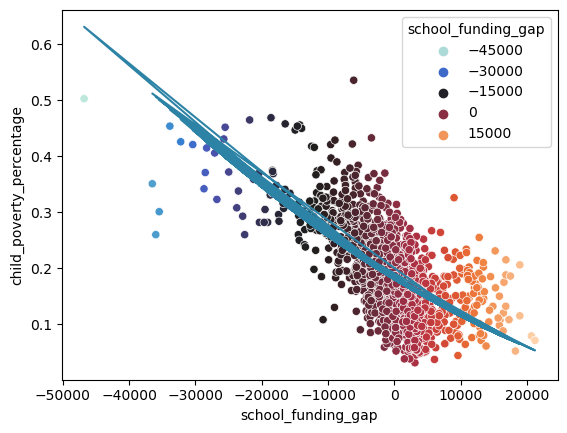

In [102]:
sns.scatterplot(x = X_1, y = y_1, hue = X_1, palette ='icefire') 
plt.plot(X_1, y_predicted, color=line_color_1)

### Income Inequality Median Income 

In [103]:
poly_features_2 = poly.fit_transform(X_2.values.reshape(-1, 1))
# Create a polynomial regression model
poly_reg_model_2 = LinearRegression()
poly_reg_model_2.fit(poly_features_2, y_3)
# Make predictions  
y_predicted_2 = poly_reg_model_2.predict(poly_features_2)

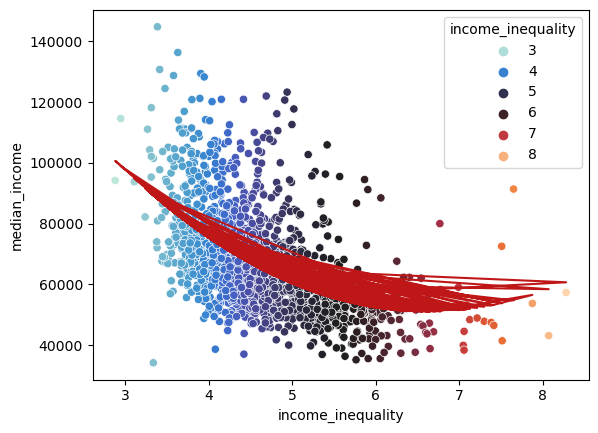

In [104]:
sns.scatterplot(x = X_2, y = y_3, hue = X_2, palette ='icefire') 
plt.plot(X_2, y_predicted_2, color=line_color_2)

# Group Observations

## Defining Groups

In [108]:
grouped_df = agg_select_subset.copy()
# adding column with inequality quantile 
grouped_df['quartile_income_inequality'] = pd.qcut(grouped_df['income_inequality'], q=4, labels=False)
# adding column defining whether county meets federal school funding requirements
grouped_df['meeting_school_funding_requirement'] = np.where(grouped_df['school_funding_gap']>=0, 'yes', 'no')
school_funding_grouped = grouped_df.groupby('meeting_school_funding_requirement')
income_inequality_grouped = grouped_df.groupby('quartile_income_inequality')

### Descriptive Stats Accross Groups

In [109]:
school_funding_grouped.describe().round(2)

school_funding_gap                    \
                                                count     mean      std   
meeting_school_funding_requirement                                        
no                                              875.0 -4815.79  5483.21   
yes                                             773.0  3735.09  3906.57   

                                                                        \
                                         min      25%      50%     75%   
meeting_school_funding_requirement                                       
no                                 -46776.99 -6134.39 -3126.54 -1410.7   
yes                                     1.63  1182.52  2472.09  4430.5   

                                             child_poverty_percentage        \
                                         max                    count  mean   
meeting_school_funding_requirement                                            
no                                     -0.25                    875.0  0.23   
yes                                 21187.84                    773.0  0.15   

                                    ... premature_death            \
                                    ...             75%       max   
meeting_school_funding_requirement  ...                             
no                                  ...        13711.18  27851.41   
yes                                 ...        10292.25  22436.81   

                                   quartile_income_inequality              \
                                                        count  mean   std   
meeting_school_funding_requirement                                          
no                                                      875.0  1.80  1.09   
yes                                                     773.0  1.15  1.05   

                                                             
                                    min  25%  50%  75%  max  
meeting_school_funding_requirement                           
no                                  0.0  1.0  2.0  3.0  3.0  
yes                                 0.0  0.0  1.0  2.0  3.0  

[2 rows x 64 columns]

In [110]:
income_inequality_grouped.describe().round(2)

school_funding_gap                              \
                                        count     mean      std       min   
quartile_income_inequality                                                  
0                                       415.0  1283.16  4454.76 -46776.99   
1                                       410.0   343.50  5061.11 -33847.18   
2                                       411.0  -253.23  5797.63 -23516.77   
3                                       412.0 -4601.62  8132.18 -36495.30   

                                                                 \
                                25%      50%      75%       max   
quartile_income_inequality                                        
0                           -797.90  1261.39  3061.95  18231.33   
1                          -2316.61   134.71  2460.44  21187.84   
2                          -3365.77  -524.42  2039.25  18898.09   
3                          -7886.41 -3698.88    20.30  18897.74   

                           child_poverty_percentage        ...  \
                                              count  mean  ...   
quartile_income_inequality                                 ...   
0                                             415.0  0.13  ...   
1                                             410.0  0.17  ...   
2                                             411.0  0.20  ...   
3                                             412.0  0.26  ...   

                           life_expectancy        premature_death            \
                                       75%    max           count      mean   
quartile_income_inequality                                                    
0                                    78.55  83.76           415.0   8403.42   
1                                    76.99  82.18           410.0   9797.68   
2                                    76.38  89.67           411.0  10886.34   
3                                    74.49  82.36           412.0  12855.18   

                                                                            \
                                std      min       25%       50%       75%   
quartile_income_inequality                                                   
0                           2268.09  3990.29   6864.09   8307.46   9670.95   
1                           2386.14  4276.04   8195.96   9699.57  11381.38   
2                           2833.99  4321.36   8889.13  10984.49  12661.47   
3                           3813.64  4157.99  10408.09  12912.68  14843.19   

                                      
                                 max  
quartile_income_inequality            
0                           19407.34  
1                           18377.17  
2                           18735.53  
3                           27851.41  

[4 rows x 56 columns]

## Overview

### Distributions: School Funding

### Across Schools Meeting Federal School Funding Requirements per pupil and those failing to meet them 

In [111]:
group_palette = {'yes': '#2D83A6', 'no': '#401616', 1:'#2D83A6' , 0: '#5FCDD9', 2: '#BF1717',  3: '#401616'}

### Across Quartiles of Income Inequality 

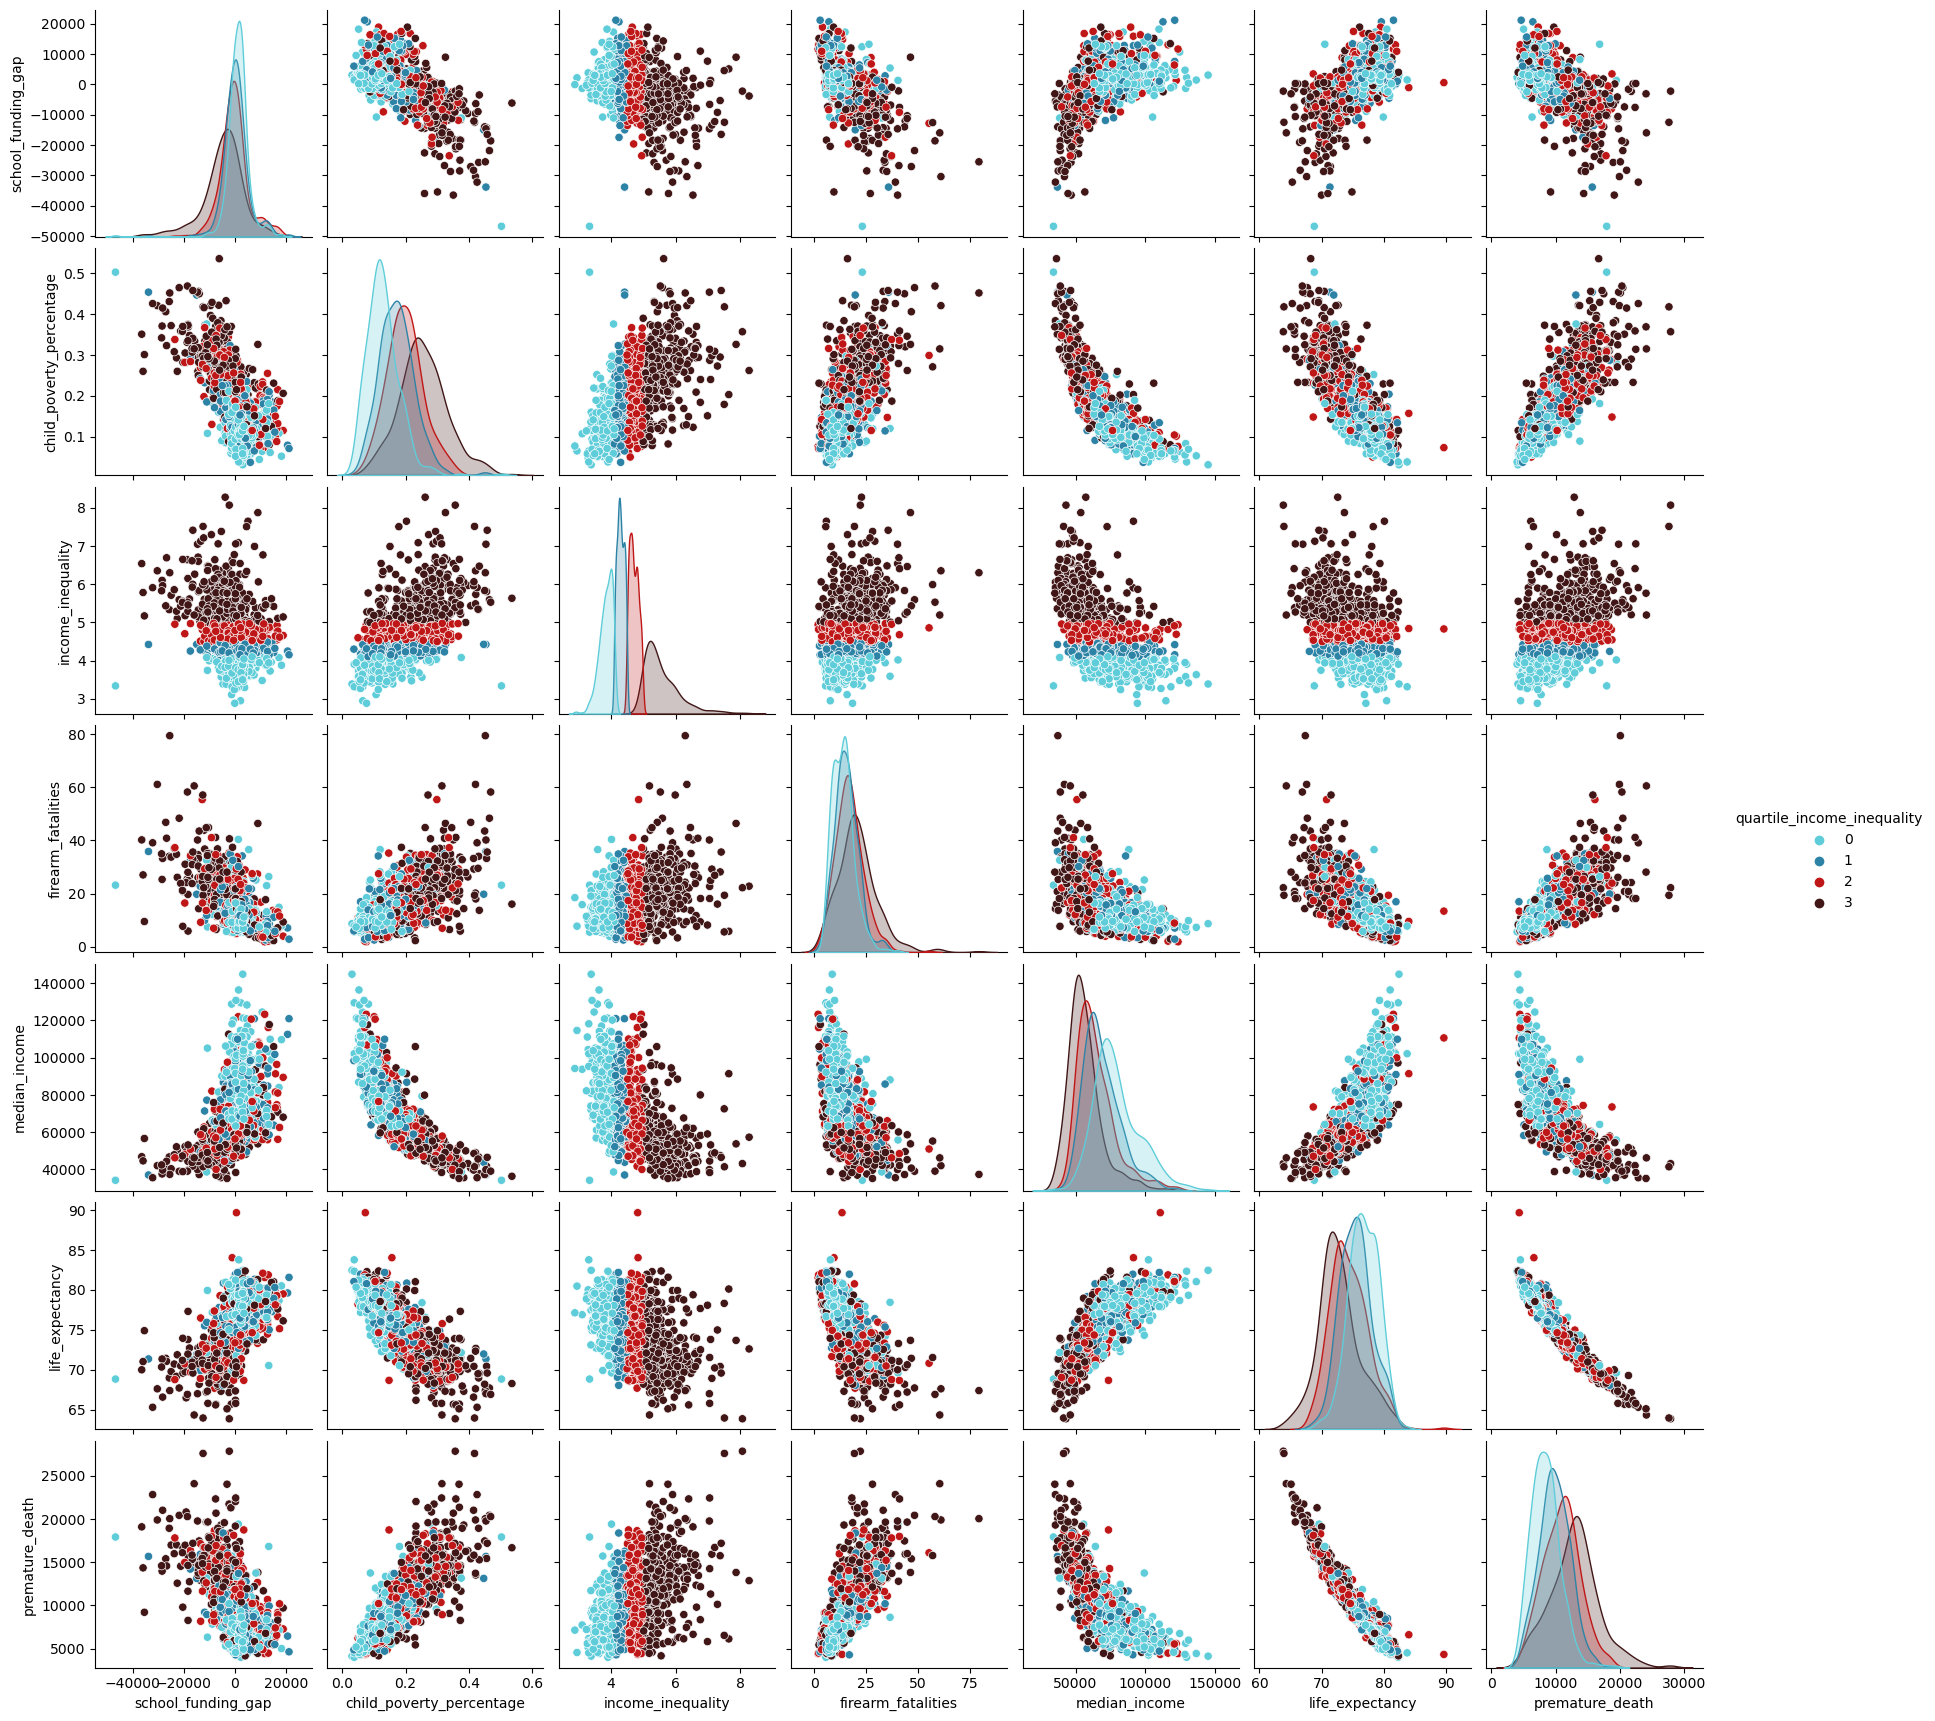

In [112]:
sns.pairplot(grouped_df, hue='quartile_income_inequality', palette=group_palette)
plt.show()

# Chi-Squared Testing

## Test- Aggregate

In [132]:
from scipy.stats import chi2_contingency
# Defining a function to perform the Chi-Square Test and interpret results
def perform_chi_square_test(data, col1, col2):
    # Creating a contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])

    # Performing the Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Interpreting the result
    significant = p < 0.05  # 5% significance level
    return chi2, p, significant

# Additional aspects to test 
additional_aspects_to_test = {
    'Whether School meets required federal funding and child poverty': ('meeting_school_funding_requirement', 'child_poverty_percentage'),
    'Whether School meets required federal funding and firearm fatalities': ('meeting_school_funding_requirement', 'firearm_fatalities'),
    'Whether School meets required federal funding and life expectancy': ('meeting_school_funding_requirement', 'life_expectancy'),
    'Whether School meets required federal funding and median income': ('meeting_school_funding_requirement', 'median_income'),
    'Whether School meets required federal funding and premature death': ('meeting_school_funding_requirement', 'premature_death'),
    'Income Inequality Quartile and child poverty': ('quartile_income_inequality', 'child_poverty_percentage'),
    'Income Inequality Quartile and firearm fatalities': ('quartile_income_inequality', 'firearm_fatalities'),
    'Income Inequality Quartile and life expectancy': ('quartile_income_inequality', 'life_expectancy'),
    'Income Inequality Quartile and median income': ('quartile_income_inequality', 'median_income'),
    'Income Inequality Quartile and premature death': ('quartile_income_inequality', 'premature_death'),
    'Political Party and child poverty': ('political_party', 'child_poverty_percentage'),
    'Political Party and firearm fatalities': ('political_party', 'firearm_fatalities'),
    'Political Party and life expectancy': ('political_party', 'life_expectancy'),
    'Political Party and median income': ('political_party', 'median_income'),
    'Political Party and premature death': ('political_party', 'premature_death'),
}


In [133]:
additional_mat_chi_square_results = {aspect: perform_chi_square_test(grouped_df, *columns) for aspect, columns in additional_aspects_to_test.items()}
additional_mat_chi_square_results

{'Whether School meets required federal funding and child poverty': (np.float64(653.4111500985841),
  np.float64(1.2842473003621774e-22),
  np.True_),
 'Whether School meets required federal funding and firearm fatalities': (np.float64(1589.1077306720877),
  np.float64(0.4451122833120476),
  np.False_),
 'Whether School meets required federal funding and life expectancy': (np.float64(1581.076966672827),
  np.float64(0.31669809901063806),
  np.False_),
 'Whether School meets required federal funding and median income': (np.float64(1621.2307866691308),
  np.float64(0.47970268362438123),
  np.False_),
 'Whether School meets required federal funding and premature death': (np.float64(1648.0),
  np.float64(0.48841810656984014),
  np.False_),
 'Income Inequality Quartile and child poverty': (np.float64(1538.0970210044675),
  np.float64(8.140812283636531e-25),
  np.True_),
 'Income Inequality Quartile and firearm fatalities': (np.float64(4754.5868023992),
  np.float64(0.4621873864586245),
  np

# Conclusion